# Question 4

## Imports

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Part (a): Loading the Dataset

In [2]:
data = load_iris()
X = data.data
y = data.target

def one_hot_encode(y, num_classes): #for one-hot-encoding the target labels
    return np.eye(num_classes)[y]

## Part (b): Preprocessing the Data

In [3]:
#1. Splitting the data into training (60%) and test (40%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#2. i) Normalization (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
X_train_norm = scaler_minmax.fit_transform(X_train)
X_test_norm = scaler_minmax.transform(X_test)

#2. ii) Standardization (Z-score Normalization)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

#2. iii) Raw data (no preprocessing)
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

## Part (c): Implementing Softmax Function

In [4]:
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

## Part (d): Implementing Multiclass Logistic Regression

In [ ]:
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

In [5]:
class MulticlassLogisticRegression: #creating a separate class for implementing logistic regression
    def __init__(self, n_features, n_classes, learning_rate=0.01, random_state=None): #defining basics
        self.n_features = n_features
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        np.random.seed(random_state)
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros(n_classes)
    
    def fit(self, X, y, method='gd', epochs=1000):
        y_onehot = one_hot_encode(y, self.n_classes)
        m = X.shape[0]
        loss_history = []
        
        if method == 'gd':
            for epoch in range(epochs):
                logits = X @ self.W + self.b
                y_pred = softmax(logits)
                loss = cross_entropy_loss(y_onehot, y_pred)
                loss_history.append(loss)
                
                grad_W = (X.T @ (y_pred - y_onehot)) / m
                grad_b = np.sum(y_pred - y_onehot, axis=0) / m
                
                self.W -= self.learning_rate * grad_W
                self.b -= self.learning_rate * grad_b
        
        elif method == 'sgd':
            for epoch in range(epochs):
                shuffled_idx = np.random.permutation(m)
                X_shuffled = X[shuffled_idx]
                y_shuffled = y_onehot[shuffled_idx]
                
                epoch_loss = 0
                for i in range(m):
                    xi = X_shuffled[i].reshape(1, -1)
                    yi = y_shuffled[i].reshape(1, -1)
                    
                    logits = xi @ self.W + self.b
                    y_pred_i = softmax(logits)
                    loss_i = cross_entropy_loss(yi, y_pred_i)
                    epoch_loss += loss_i
                    
                    grad_W_i = xi.T @ (y_pred_i - yi)
                    grad_b_i = np.sum(y_pred_i - yi, axis=0)
                    
                    self.W -= self.learning_rate * grad_W_i
                    self.b -= self.learning_rate * grad_b_i
                
                loss_history.append(epoch_loss / m)
        
        return loss_history
    
    def predict(self, X):
        logits = X @ self.W + self.b
        return np.argmax(softmax(logits), axis=1)

In [6]:
#previously defined preprocessing methods in part (b)
preprocess_methods = {
    'Raw': (X_train_raw, X_test_raw),
    'MinMax': (X_train_norm, X_test_norm),
    'Standardized': (X_train_std, X_test_std)
}

results = {}

#implementing gradient and stochastic gradient descent and keeping track of loss
for method_name, (X_tr, X_te) in preprocess_methods.items():
    # Gradient Descent
    model_gd = MulticlassLogisticRegression(4, 3, learning_rate=0.1, random_state=42)
    loss_gd = model_gd.fit(X_tr, y_train, method='gd', epochs=1000)
    
    # Stochastic Gradient Descent
    model_sgd = MulticlassLogisticRegression(4, 3, learning_rate=0.01, random_state=42)
    loss_sgd = model_sgd.fit(X_tr, y_train, method='sgd', epochs=1000)
    
    # Evaluate
    for model, opt in [(model_gd, 'GD'), (model_sgd, 'SGD')]:
        y_pred = model.predict(X_te)
        key = f"{method_name}_{opt}"
        results[key] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'loss_history': loss_gd if opt == 'GD' else loss_sgd
        }

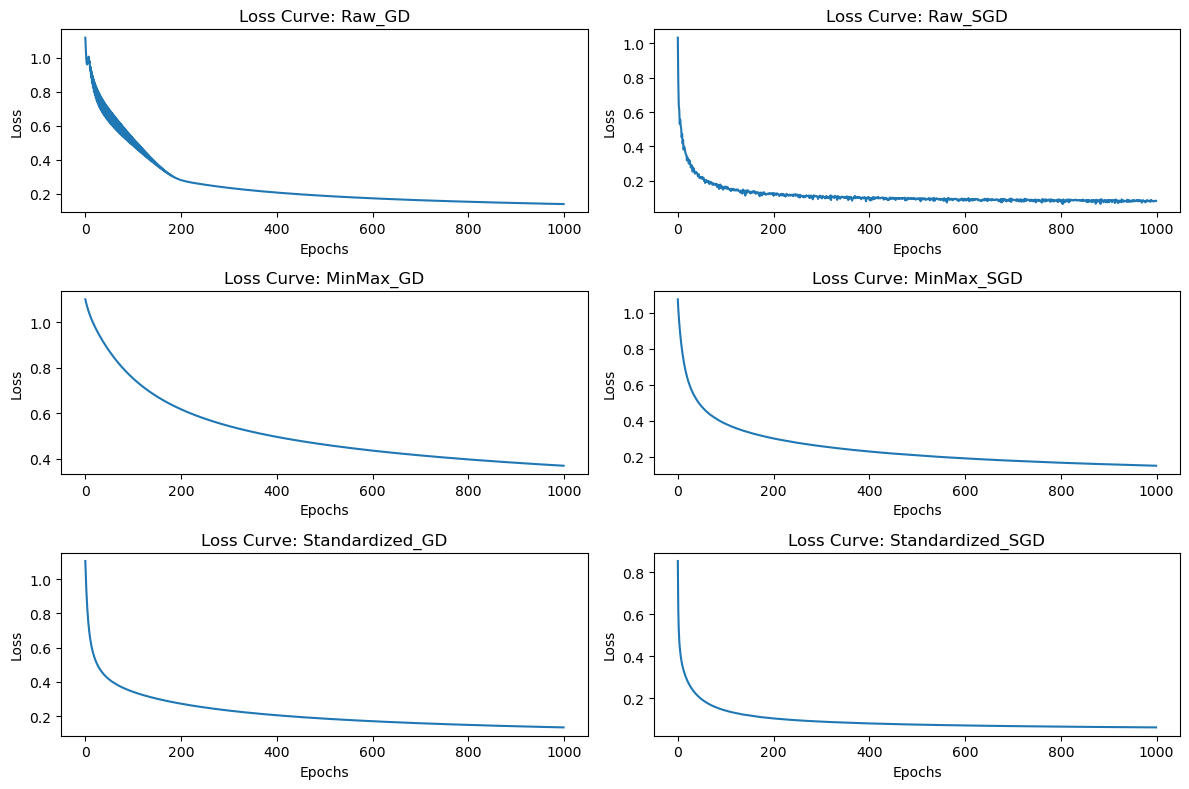

In [7]:
#plotting loss curve over epochs
plt.figure(figsize=(12, 8))
for i, (key, data) in enumerate(results.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(data['loss_history'])
    plt.title(f'Loss Curve: {key}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [8]:
#classification report, confusion matrix and accuracy
for key, data in results.items():
    print(f"\n{key} Results:")
    print(f"Accuracy: {data['accuracy']:.4f}")
    print("Classification Report:")
    print(data['report'])
    print("Confusion Matrix:")
    print(data['confusion_matrix'])


Raw_GD Results:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion Matrix:
[[23  0  0]
 [ 0 19  0]
 [ 0  0 18]]

Raw_SGD Results:
Accuracy: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.95      0.95      0.95        19
           2       0.94      0.94      0.94        18

    accuracy                           0.97        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.97      0.97      0.97        60

Confusion Matrix:
[[23  0  0]
 [ 0 18  1]
 [ 0  1 17]]

MinMax_GD Re